In [27]:
# Import libraries
import statsapi
import requests as re
import pandas as pd
import datetime
import numpy as np
import re
from tqdm import tqdm
import time
import more_itertools as mit
from bs4 import BeautifulSoup
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
# Read in training data
df = pd.concat([pd.read_csv('3game/2014.csv'),pd.read_csv('3game/2015.csv'),
                pd.read_csv('3game/2016.csv'),pd.read_csv('3game/2017.csv'),
                pd.read_csv('3game/2018.csv'),pd.read_csv('3game/2019.csv')])

In [3]:
df

,game_id_1,game_date_1,away_name_1,home_name_1,away_id_1,home_id_1,HP_1,temp_1,weather_1,mag_1,dir_1,length_1,att_1,daytime_1,delay_1,away_LOB_1,away_RISP_1,away_GIDP_1,away_2outrunners_1,away_2outrbi_1,home_LOB_1,home_RISP_1,home_GIDP_1,home_2outrunners_1,home_2outrbi_1,away_runs_1,away_doubles_1,away_triples_1,away_homeRuns_1,away_strikeOuts_1,away_baseOnBalls_1,away_hits_1,away_avg_1,away_atBats_1,away_obp_1,away_slg_1,away_ops_1,away_stolenBases_1,away_rbi_1,away_leftOnBase_1,home_runs_1,home_doubles_1,home_triples_1,home_homeRuns_1,home_strikeOuts_1,home_baseOnBalls_1,home_hits_1,home_avg_1,home_atBats_1,home_obp_1,home_slg_1,home_ops_1,home_stolenBases_1,home_rbi_1,home_leftOnBase_1,days_1,game_id_2,game_date_2,away_name_2,home_name_2,away_id_2,home_id_2,HP_2,temp_2,weather_2,mag_2,dir_2,length_2,att_2,daytime_2,delay_2,away_LOB_2,away_RISP_2,away_GIDP_2,away_2outrunners_2,away_2outrbi_2,home_LOB_2,home_RISP_2,home_GIDP_2,home_2outrunners_2,home_2outrbi_2,away_runs_2,away_doubles_2,away_triples_2,away_homeRuns_2,away_strikeOuts_2,away_baseOnBalls_2,away_hits_2,away_avg_2,away_atBats_2,away_obp_2,away_slg_2,away_ops_2,away_stolenBases_2,away_rbi_2,away_leftOnBase_2,home_runs_2,home_doubles_2,home_triples_2,home_homeRuns_2,home_strikeOuts_2,home_baseOnBalls_2,home_hits_2,home_avg_2,home_atBats_2,home_obp_2,home_slg_2,home_ops_2,home_stolenBases_2,home_rbi_2,home_leftOnBase_2,days_2,game_id,game_date,away_name,home_name,away_id,home_id,HP,temp,weather,mag,dir,length,att,daytime,delay,away_LOB,away_RISP,away_GIDP,away_2outrunners,away_2outrbi,home_LOB,home_RISP,home_GIDP,home_2outrunners,home_2outrbi,away_runs,away_doubles,away_triples,away_homeRuns,away_strikeOuts,away_baseOnBalls,away_hits,away_avg,away_atBats,away_obp,away_slg,away_ops,away_stolenBases,away_rbi,away_leftOnBase,home_runs,home_doubles,home_triples,home_homeRuns,home_strikeOuts,home_baseOnBalls,home_hits,home_avg,home_atBats,home_obp,home_slg,home_ops,home_stolenBases,home_rbi,home_leftOnBase,days
0,380687,2014-04-11,Los Angeles Dodgers,Arizona Diamondbacks,119,109,Will Little,92,Partly Cloudy,1 mph,R To L.,146,33349.0,6:40 PM,0,3,3-for-6,2,1,2,3,0-for-1000,1,0,0,6,3,0,1,6,1,10,0.255,35,0.316,0.416,0.731,1,6,8,0,0,0,0,11,2,2,0.248,28,0.298,0.371,0.669,0,0,9,100,380702,2014-04-12,Los Angeles Dodgers,Arizona Diamondbacks,119,109,Tim Timmons,87,Clear,10 mph,L To R.,227,38374.0,5:10 PM,0,11,4-for-15,1,5,4,11,3-for-14,0,8,3,8,4,0,1,7,6,12,0.260,39,0.324,0.422,0.746,0,7,25,5,3,0,1,12,2,12,0.253,38,0.304,0.379,0.683,1,5,20,101,380717,2014-04-13,Los Angeles Dodgers,Arizona Diamondbacks,119,109,Todd Tichenor,75,Roof Closed,0 mph,None.,219,31757.0,1:10 PM,0,6,2-for-11,0,3,1,9,3-for-16,1,6,3,8,1,0,3,16,6,7,0.255,35,0.323,0.427,0.751,5,7,14,6,4,1,2,11,2,14,0.261,39,0.311,0.400,0.711,2,6,21,102
1,381159,2014-05-16,Los Angeles Dodgers,Arizona Diamondbacks,119,109,Jeff Kellogg,100,Overcast,8 mph,L To R.,174,31154.0,6:40 PM,0,8,3-for-9,0,4,3,5,0-for-6,3,2,0,7,4,0,2,8,5,10,0.259,37,0.325,0.412,0.738,0,7,13,0,0,0,0,8,3,5,0.251,29,0.303,0.382,0.686,0,0,14,135,381174,2014-05-17,Los Angeles Dodgers,Arizona Diamondbacks,119,109,Quinn Wolcott,78,Roof Closed,0 mph,None.,235,36688.0,5:10 PM,0,8,2-for-15,1,5,0,8,10-for-20,1,5,8,7,4,0,2,7,2,13,0.261,40,0.326,0.417,0.743,0,7,20,18,5,3,5,9,6,21,0.258,43,0.310,0.402,0.712,2,18,17,136,381189,2014-05-18,Los Angeles Dodgers,Arizona Diamondbacks,119,109,Paul Schrieber,74,Roof Closed,0 mph,None.,170,35406.0,1:13 PM,0,7,1-for-4,1,3,3,6,3-for-11,0,3,2,3,0,0,2,6,3,7,0.260,33,0.326,0.416,0.742,1,3,10,5,2,0,2,4,0,11,0.259,35,0.311,0.405,0.715,2,4,16,137
2,381640,2014-06-20,Los Angeles Dodgers,San Diego Padres,119,135,Paul Schrieber,69,Clear,7 mph,L To R.,192,31119.0,7:10 PM,0,5,3-for-7,0,3,1,6,2-for-8,0,3,1,5,2,1,0,6,2,9,0.258,34,0.329,0.408,0.737,1,4,10,6,4,0,2,6,3,9,0.214,33,0.275,0.341,0.616,1,6,13,170,381655,2014-06-21,Los Angeles Dodgers,San Diego Padres,119,135,Ted Barrett,68,Partly Cloudy,6 mph,L To R.,187,43474.0,7:10 PM,0,6,3-for-10,0,3,1

In [4]:
# drop columns we dont need
df = df.drop(columns=['game_id_1','game_id_2','game_id', 'away_name_1', 'away_name_2','away_name', 'home_name_1','home_name_2',
                 'home_name', 'away_id_1','away_id_2','home_id_1','home_id_2','days_1','days_2','days','HP','length','att',
                 'delay','away_LOB','away_RISP','away_LOB', 'away_RISP', 'away_GIDP', 'away_2outrunners',
                   'away_2outrbi', 'home_LOB', 'home_RISP', 'home_GIDP',
                   'home_2outrunners', 'home_2outrbi', 'away_doubles',
                   'away_triples', 'away_homeRuns', 'away_strikeOuts', 'away_baseOnBalls',
                   'away_hits', 'away_avg', 'away_atBats', 'away_obp', 'away_slg',
                   'away_ops', 'away_stolenBases', 'away_rbi', 'away_leftOnBase',
                'home_doubles', 'home_triples', 'home_homeRuns',
                   'home_strikeOuts', 'home_baseOnBalls', 'home_hits', 'home_avg',
                   'home_atBats', 'home_obp', 'home_slg', 'home_ops', 'home_stolenBases',
                   'home_rbi', 'home_leftOnBase'])

In [5]:
# Add up total runs for game 3
df['runs'] = df['away_runs'] + df['home_runs']

In [6]:
# Convert RISP from string to float
df['away_RISP_1'] = df['away_RISP_1'].apply(lambda x: int(re.search(r'(\d*)-for-(\d*)', x).group(1)) / int(re.search(r'(\d*)-for-(\d*)', x).group(2)))
df['home_RISP_1'] = df['home_RISP_1'].apply(lambda x: int(re.search(r'(\d*)-for-(\d*)', x).group(1)) / int(re.search(r'(\d*)-for-(\d*)', x).group(2)))
df['away_RISP_2'] = df['away_RISP_2'].apply(lambda x: int(re.search(r'(\d*)-for-(\d*)', x).group(1)) / int(re.search(r'(\d*)-for-(\d*)', x).group(2)))
df['home_RISP_2'] = df['home_RISP_2'].apply(lambda x: int(re.search(r'(\d*)-for-(\d*)', x).group(1)) / int(re.search(r'(\d*)-for-(\d*)', x).group(2)))

In [7]:
# Filter out some independent variables
train = pd.concat([df.loc[:,'away_LOB_1':'home_leftOnBase_1'], df.loc[:,'away_LOB_2':'home_leftOnBase_2']],axis=1)

In [8]:
# Game result dummy for games 1 and 2
train['awaywon_1'] = (train['away_runs_1'] >= train['home_runs_1']).astype(int)
train['awaywon_2'] = (train['away_runs_2'] >= train['home_runs_2']).astype(int)

In [9]:
# If the away team won both games
train['awaywonboth'] = train['awaywon_1'] * train['awaywon_2']

In [10]:
# If the home team won both games
train['homewonboth'] = ((train['awaywon_1'] == 0) * (train['awaywon_2'] == 0)).astype(int)

C:\Users\leowe\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [11]:
# Add in the weather data we left out earlier
train['temp_1'] = df['temp_1']
train['temp_2'] = df['temp_2']
train['weather_1'] = df['weather_1']
train['weather_2'] = df['weather_2']

In [12]:
# Put rare weather cases into the same category "other"
train['weather_1'] = train['weather_1'].replace('Rain','Other').replace('Drizzle','Other').replace('Snow','Other')
train['weather_2'] = train['weather_2'].replace('Rain','Other').replace('Drizzle','Other').replace('Snow','Other')

In [13]:
# Add up total runs for games 1 and 2
train['runs_1'] = train['away_runs_1'] + train['home_runs_1']
train['runs_2'] = train['away_runs_2'] + train['home_runs_2']

In [14]:
# get dummy variables 
train = pd.concat([train, pd.get_dummies(train['weather_1'],prefix='1'), pd.get_dummies(train['weather_2'],prefix='2')],axis=1).drop(columns=['weather_1','weather_2'])

In [16]:
train

,away_LOB_1,away_RISP_1,away_GIDP_1,away_2outrunners_1,away_2outrbi_1,home_LOB_1,home_RISP_1,home_GIDP_1,home_2outrunners_1,home_2outrbi_1,away_runs_1,away_doubles_1,away_triples_1,away_homeRuns_1,away_strikeOuts_1,away_baseOnBalls_1,away_hits_1,away_avg_1,away_atBats_1,away_obp_1,away_slg_1,away_ops_1,away_stolenBases_1,away_rbi_1,away_leftOnBase_1,home_runs_1,home_doubles_1,home_triples_1,home_homeRuns_1,home_strikeOuts_1,home_baseOnBalls_1,home_hits_1,home_avg_1,home_atBats_1,home_obp_1,home_slg_1,home_ops_1,home_stolenBases_1,home_rbi_1,home_leftOnBase_1,away_LOB_2,away_RISP_2,away_GIDP_2,away_2outrunners_2,away_2outrbi_2,home_LOB_2,home_RISP_2,home_GIDP_2,home_2outrunners_2,home_2outrbi_2,away_runs_2,away_doubles_2,away_triples_2,away_homeRuns_2,away_strikeOuts_2,away_baseOnBalls_2,away_hits_2,away_avg_2,away_atBats_2,away_obp_2,away_slg_2,away_ops_2,away_stolenBases_2,away_rbi_2,away_leftOnBase_2,home_runs_2,home_doubles_2,home_triples_2,home_homeRuns_2,home_strikeOuts_2,home_baseOnBalls_2,home_hits_2,home_avg_2,home_atBats_2,home_obp_2,home_slg_2,home_ops_2,home_stolenBases_2,home_rbi_2,home_leftOnBase_2,awaywon_1,awaywon_2,awaywonboth,homewonboth,temp_1,temp_2,runs_1,runs_2,1_Clear,1_Cloudy,1_Dome,1_Other,1_Overcast,1_Partly Cloudy,1_Roof Closed,1_Sunny,2_Clear,2_Cloudy,2_Dome,2_Other,2_Overcast,2_Partly Cloudy,2_Roof Closed,2_Sunny
0,3,0.500000,2,1,2,3,0.000000,1,0,0,6,3,0,1,6,1,10,0.255,35,0.316,0.416,0.731,1,6,8,0,0,0,0,11,2,2,0.248,28,0.298,0.371,0.669,0,0,9,11,0.266667,1,5,4,11,0.214286,0,8,3,8,4,0,1,7,6,12,0.260,39,0.324,0.422,0.746,0,7,25,5,3,0,1,12,2,12,0.253,38,0.304,0.379,0.683,1,5,20,1,1,1,0,92,87,6,13,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
1,8,0.333333,0,4,3,5,0.000000,3,2,0,7,4,0,2,8,5,10,0.259,37,0.325,0.412,0.738,0,7,13,0,0,0,0,8,3,5,0.251,29,0.303,0.382,0.686,0,0,14,8,0.133333,1,5,0,8,0.500000,1,5,8,7,4,0,2,7,2,13,0.261,40,0.326,0.417,0.743,0,7,20,18,5,3,5,9,6,21,0.258,43,0.310,0.402,0.712,2,18,17,1,0,0,0,100,78,7,25,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2,5,0.428571,0,3,1,6,0.250000,0,3,1,5,2,1,0,6,2,9,0.258,34,0.329,0.408,0.737,1,4,10,6,4,0,2,6,3,9,0.214,33,0.275,0.341,0.616,1,6,13,6,0.300000,0,3,1,8,0.400000,0,1,2,4,1,0,0,9,3,8,0.258,32,0.328,0.407,0.735,1,4,14,2,0,1,0,10,3,8,0.215,34,0.275,0.341,0.616,0,2,14,0,1,0,0,69,68,11,6,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,11,0.111111,0,6,1,11,0.200000,0,4,1,2,2,0,1,15,3,11,0.260,46,0.328,0.393,0.721,1,2,23,3,0,0,0,9,6,8,0.226,40,0.290,0.344,0.634,0,2,20,10,0.000000,0,4,1,5,0.333333,1,1,0,1,1,0,1,10,3,8,0.259,38,0.327,0.393,0.720,1,1,16,2,3,0,0,9,3,7,0.226,32,0.290,0.343,0.634,1,2,10,0,0,0,1,75,77,5,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,11,0.272727,0,5,3,5,0.666667,0,1,2,5,4,0,0,6,4,12,0.258,37,0.329,0.396,0.725,2,5,16,2,0,0,0,6,1,6,0.256,33,0.331,0.386,0.717,0,2,7,9,0.285714,0,5,1,8,0.307692,0,6,4,7,0,0,2,8,5,9,0.258,35,0.329,0.397,0.726,0,7,12,12,2,0,3,6,5,12,0.257,35,0.333,0.389,0.722,0,11,17,1,0,0,0,85,87,7,19,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464,8,0.222222,0,3,0,5,0.000000,1,2,0,7,2,0,3,7,7,9,0.246,34,0.322,0.442,0.764,0,7,15,0,0,0,0,11,0,4,0.254,30,0.309,0.399,0.708,1,0,9,13,0.000000,3,7,0,5,0.000000,0,2,1,2,1,0,0,7,7,10,0.246,35,0.323,0.441,0.763,0,0,21,3,2,0,1,9,1,7,0.254,30,0.308,0.399,0.707,2,2,12,1,0,0,0,78,81,7,5,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
465,7,0.285714,0,3,2,9,0.300000,1,3,1,2,1,0,0,7,3,7,0.230,33,0.305,0.391,0.695,1,2,16,3,1,0,1,9,4,9,0.240,32,0.311,0.368,0.679,0,3,16,9,0.000000,1,4,0,6,0.142857,1,3,0,0,1,0,0,7,4,6,0.226,32,0.302,0.377,0.679,0,0,18,6,3,0,3,4,2,11,0.250,34,0.317,0.404,0.721,0,6,12,0,0,0,1,76,73,5,6,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


In [18]:
# split to train and test data 
x_train, x_test, y_train, y_test = train_test_split(train, df['runs'], test_size=0.1, random_state=0)

In [29]:
# Fit a linear regression
lr = LinearRegression().fit(x_train,y_train)

(array([ 1.,  6., 27., 52., 80., 79., 38., 12.,  5.,  3.]),
 array([ 4.78991699,  5.622052  ,  6.45418701,  7.28632202,  8.11845703,
         8.95059204,  9.78272705, 10.61486206, 11.44699707, 12.27913208,
        13.11126709]),
 <a list of 10 Patch objects>)

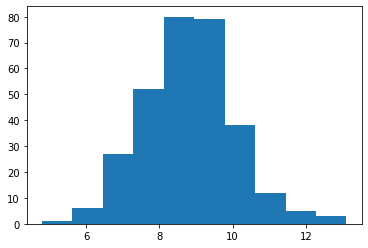

In [31]:
# histogram of predictions
plt.hist(lr.predict(x_test))

In [32]:
# cross validation error
np.mean(cross_val_score(lr, train, df['runs'], scoring='neg_mean_absolute_error', cv=10))

-3.5186313832411784

In [19]:
# Fit a random forest
rf = RandomForestRegressor()
rf.fit(x_train, y_train)

RandomForestRegressor()

In [20]:
# cross validation error
np.mean(cross_val_score(rf, train, df['runs'], scoring='neg_mean_absolute_error', cv=10))

-3.5250123707735015

Predictions falling mainly in the 8 to 10 category is not of much significance and building a random forest model that is more complicated than a linear regression doesn't improve the cross validation error, so I decided to modify my approach that can lead to 3 times more data samples by predicting game by game rather than predicting the final game of a 3-game series.